In [5]:
%matplotlib inline


## Single estimator versus bagging



Automatically created module for IPython interactive environment


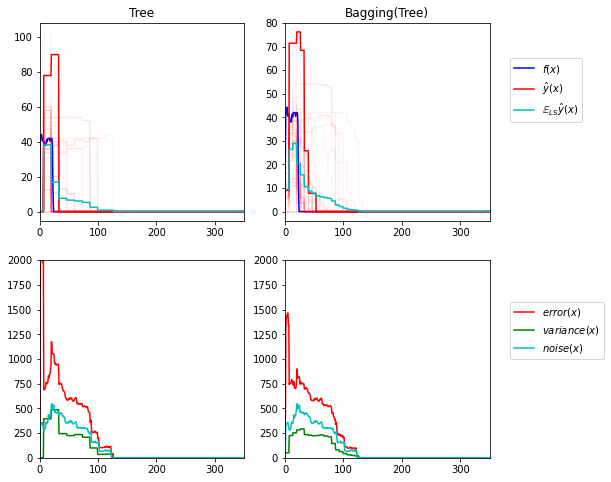

In [4]:
from scipy.interpolate import interp1d
print(__doc__)


import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
import glob
# Settings
n_repeat = 50       # Number of iterations for computing expectations
n_train = 50        # Size of the training set
n_test = 1000      # Size of the test set
noise = 0.1         # Standard deviation of the noise
np.random.seed(0)

# Change this for exploring the bias-variance decomposition of other
# estimators. This should work well for estimators with high variance (e.g.,
# decision trees or KNN), but poorly for estimators with low variance (e.g.,
# linear models).
estimators = [("Tree", DecisionTreeRegressor()),
              ("Bagging(Tree)", BaggingRegressor(DecisionTreeRegressor()))]

n_estimators = len(estimators)
ts_files = glob.glob("data/csv_Washbasin/cluster_0/*.csv")
f_true = "data/csv_Washbasin/0_spline.csv"

def f(x, iteration):

    if iteration==-1:
        ts = np.genfromtxt(ts_files[4], delimiter=" ")
    else:
        ts = np.genfromtxt(ts_files[iteration], delimiter=" ")
    start_time = ts[0,0]
    ts[:,0] -= start_time
    ts[0,1] = 0
    if ts[-1,0] < 650:
        ts = np.vstack((ts,[ts[-1,0]+1, 0]))
        ts = np.vstack((ts,[650, 0]))

    for i in range(1,len(ts)-1):
        if ts[i,1]==0 and ts[i+1,1]!=0:
            ts[i,1]=(ts[i-1,1]+ts[i+1,1])*0.5
    linfunc = interp1d(ts[:,0], ts[:,1])
    return linfunc(x)



def generate(n_samples, n_repeat=1):
    X = np.linspace(0, 650, n_samples)

    if n_repeat == 1:
        y = f(X, np.random.randint(1,len(ts_files)))
    else:
        y = np.zeros((n_samples, n_repeat))

        for i in range(n_repeat):
            y[:, i] = f(X, np.random.randint(1,len(ts_files)))

    X = X.reshape((n_samples, 1))

    return X, y


X_train = []
y_train = []

for i in range(n_repeat):
    X, y = generate(n_samples=n_train)
    X_train.append(X)
    y_train.append(y)

X_test, y_test = generate(n_samples=n_test,  n_repeat=n_repeat)

plt.figure(figsize=(10, 8))

# Loop over estimators to compare
for n, (name, estimator) in enumerate(estimators):
    # Compute predictions
    y_predict = np.zeros((n_test, n_repeat))

    for i in range(n_repeat):
        estimator.fit(X_train[i], y_train[i])
        y_predict[:, i] = estimator.predict(X_test)


    y_error = np.zeros(n_test)

    for i in range(n_repeat):
        for j in range(n_repeat):
            y_error += (y_test[:, j] - y_predict[:, i]) ** 2

    y_error /= (n_repeat * n_repeat)

    y_noise = np.var(y_test, axis=1)
    y_var = np.var(y_predict, axis=1)




    # Plot figures
    plt.subplot(2, n_estimators, n + 1)
    plt.plot(X_test, f(X_test,-1), "b", label="$f(x)$")
    for i in range(n_repeat):
        if i == 0:
            plt.plot(X_test, y_predict[:, i], "r", label=r"$\^y(x)$")
        else:
            plt.plot(X_test, y_predict[:, i], "r", alpha=0.05)

    plt.plot(X_test, np.mean(y_predict, axis=1), "c",
             label=r"$\mathbb{E}_{LS} \^y(x)$")

    plt.xlim([0, 350])
    plt.title(name)

    if n == n_estimators - 1:
        plt.legend(loc=(1.1, .5))

    plt.subplot(2, n_estimators, n_estimators + n + 1)
    plt.plot(X_test, y_error, "r", label="$error(x)$")
    plt.plot(X_test, y_var, "g", label="$variance(x)$"),
    plt.plot(X_test, y_noise, "c", label="$noise(x)$")

    plt.xlim([0, 350])
    plt.ylim([0, 2000])
    if n == n_estimators - 1:

        plt.legend(loc=(1.1, .5))

plt.subplots_adjust(right=.75)
plt.show()